In [117]:
import numpy as np
import networkx as nx
import itertools
from itertools import permutations
from itertools import product
import matplotlib.pyplot as plt
import scipy.constants as scp
import pandas as pd
import statistics as stat
import random
import math
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap as Basemap

In [118]:
Cities = ["London", "Manchester", "Birmingham", "Leeds", "Glasgow"]
Positions = [(0.1276, 51.5072), (-2.2426, 53.4808), (-1.8904, 52.4862), (-1.5491, 53.8008), (-4.2518, 55.8642)]

distances = [[0,262,162,278,555], [262,0,113,59,295], [162,113,0,148,407], [272,59,148,0,288], [555,295,407,288,0]]
traffic = [[0,12,12,8,7], [12,0,3,2,2], [12,3,0,2,1], [8,2,2,0,1], [7,2,1,1,0]]
# create a dictionary of cities
cities_dict = {i : {} for i in Cities}
cities_traff = {i : {} for i in Cities}
# connect all cities with distances
for e in Cities:  
    cities_dict[e] = {i : distances[Cities.index(e)][Cities.index(i)] for i in Cities}
    cities_traff[e] = {i : traffic[Cities.index(e)][Cities.index(i)] for i in Cities}

cities_df = pd.DataFrame(cities_dict)
traffic_df = pd.DataFrame(cities_traff)
cities_df

,London,Manchester,Birmingham,Leeds,Glasgow
London,0,262,162,272,555
Manchester,262,0,113,59,295
Birmingham,162,113,0,148,407
Leeds,278,59,148,0,288
Glasgow,555,295,407,288,0


In [119]:
traffic_df

,London,Manchester,Birmingham,Leeds,Glasgow
London,0,12,12,8,7
Manchester,12,0,3,2,2
Birmingham,12,3,0,2,1
Leeds,8,2,2,0,1
Glasgow,7,2,1,1,0


In [120]:
# maybe better: create a full mesh then disconnect one by one in a loop

G=nx.Graph()
# G.add_nodes_from(Cities)
for i in range(len(Cities)):
    G.add_node(Cities[i], pos=Positions[i])
for i in cities_dict:
    for j in cities_dict[i]:
        # G.add_weighted_edges_from([(i,j,cities_dict[i][j])])
        G.add_edges_from([(i,j,{'weight':cities_dict[i][j]})])
        
# add a ROADM at every node (4dB) and amplifier (number)
nx.set_node_attributes(G,4,'ROADM')
nx.set_node_attributes(G,1,'EDFA')

# remove self-edges
G.remove_edges_from(nx.selfloop_edges(G))

# add atrributes
# G.edge['London']['Manchester']['attribute'] = 'value'

In [121]:
G.nodes()

NodeView(('London', 'Manchester', 'Birmingham', 'Leeds', 'Glasgow'))

In [122]:
G.edges()

EdgeView([('London', 'Manchester'), ('London', 'Birmingham'), ('London', 'Leeds'), ('London', 'Glasgow'), ('Manchester', 'Birmingham'), ('Manchester', 'Leeds'), ('Manchester', 'Glasgow'), ('Birmingham', 'Leeds'), ('Birmingham', 'Glasgow'), ('Leeds', 'Glasgow')])

In [123]:
G['Manchester']

AtlasView({'London': {'weight': 262}, 'Birmingham': {'weight': 113}, 'Leeds': {'weight': 59}, 'Glasgow': {'weight': 295}})

In [91]:
# ring topology
G.remove_edge('Leeds','Manchester')
G.remove_edge('Leeds','Birmingham')
G.remove_edge('Manchester','London')
G.remove_edge('Birmingham','Glasgow')
G.remove_edge('London','Glasgow')

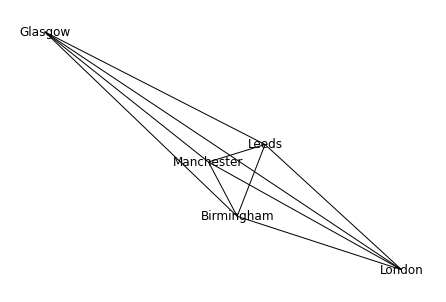

In [124]:
# nx.draw(G, pos=nx.circular_layout(G))
# nx.draw_networkx_labels(G,pos=nx.circular_layout(G))
# nx.draw_networkx_edge_labels(G,pos=nx.circular_layout(G)) 
nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=0)

In [125]:
# develop a method to drop them out one by one in a loop through all possibilities and then pairwise and so 
# on until 5 at a time (max)

# for i in Cities:
#     for j in G.neighbors(i):
#         G.remove_edge(i,j)
#         # recalulate()
#         G.add_weighted_edges_from([(i,j,cities_dict[i][j])])

# calculate all 2-pairs of edges and then remove them, same with 3, 4 and 5s
# 1. list edges 2. pair up in a list

In [126]:
# calculate values:

# 1) shortest path between any two nodes
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
paths = dict(nx.all_pairs_dijkstra_path(G))
adjacency = nx.to_pandas_adjacency(G)

link_capacities = adjacency.copy()
for col in link_capacities.columns:
    link_capacities[col].values[:] = 0

# 1.5 put traffic numbers (divided by 2 as each link has forward and back connections) 
# on each edge to show total capacity on each link -- here we assume all is going down shortest paths

for i in list(paths.keys()):
    for j in list(paths[i].keys()):
        # print(f'The shortest connection between {i} and {j} is', paths[i][j], 'with length', path_lengths[i][j])
        # add the traffic for i,j onto each segment from paths[i],[j] in link capacities
        if len(paths[i][j]) < 2:
            link_capacities[i][j] += traffic_df[i][j]
        else:
            for e in paths[i][j]:
                if e != paths[i][j][-1]:
                    link_capacities[e][paths[i][j][paths[i][j].index(e)+1]] += traffic_df[i][j]
        
# dataframes of shortest path and their lengths
paths_df = pd.DataFrame(paths)
path_lengths_df = pd.DataFrame(path_lengths)



# 2) decide amplifier locations - these should be roughly equally spaced, calc mean and longest paths
# above a certain loss value (?) so length need an amplifier, above another - two amplifiers
shortest1 = nx.shortest_path_length(G, weight="weight")
ecc = nx.eccentricity(G, sp=dict(shortest1))
diam = nx.diameter(G, e=ecc)
print('Diameter (shortest path between the most distanced nodes): ', diam)
print('Eccentricity (largest distance from a node to any other node): ', ecc)
print('Average shortest path length is: ', nx.average_shortest_path_length(G))
edge_weight_list = [G[u][v]['weight'] for (u,v) in G.edges()]
mean = stat.mean(edge_weight_list)
print('Link distances are: ', edge_weight_list)
print('Of which average, $d$, is: ', mean)
print('So place $m$ amplifiers if link longer than $m \cdot d/2$, i.e. $\beq m \cdot$', mean/2)
print('Also this allows for compensation of the total loss along the previous span (~113*0.18=20.34), has to be attenuated')
print('Total fibre deployed (2x link length) in km', 2*sum(edge_weight_list))

# dict of amplifiers per edge; think of better choosing amplifier locations
amplifiers = {}
for i in G.edges():
    m = math.floor(G[i[0]][i[1]]['weight']*2/mean)
    j = (i[1],i[0])
    amplifiers[i] = m
    amplifiers[j] = m
print(amplifiers)

Diameter (shortest path between the most distanced nodes):  555
Eccentricity (largest distance from a node to any other node):  {'London': 555, 'Manchester': 295, 'Birmingham': 407, 'Leeds': 288, 'Glasgow': 555}
Average shortest path length is:  1.0
Link distances are:  [262, 162, 272, 555, 113, 59, 295, 148, 407, 288]
Of which average, $d$, is:  256.1
So place $m$ amplifiers if link longer than $m \cdot d/2$, i.e. eq m \cdot$ 128.05
Also this allows for compensation of the total loss along the previous span (~113*0.18=20.34), has to be attenuated
Total fibre deployed (2x link length) in km 5122
{('London', 'Manchester'): 2, ('Manchester', 'London'): 2, ('London', 'Birmingham'): 1, ('Birmingham', 'London'): 1, ('London', 'Leeds'): 2, ('Leeds', 'London'): 2, ('London', 'Glasgow'): 4, ('Glasgow', 'London'): 4, ('Manchester', 'Birmingham'): 0, ('Birmingham', 'Manchester'): 0, ('Manchester', 'Leeds'): 0, ('Leeds', 'Manchester'): 0, ('Manchester', 'Glasgow'): 2, ('Glasgow', 'Manchester'): 2

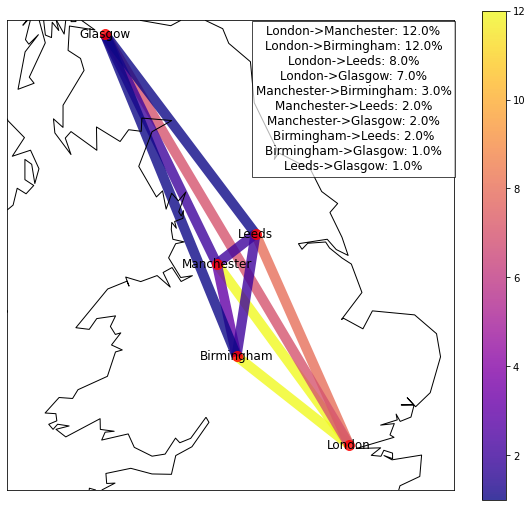

In [231]:
edge_labels = {(u,v):link_capacities[u][v] for (u,v) in G.edges()}
plt.figure(figsize = (10,9))
m = Basemap(
         projection='merc',
         llcrnrlon=-6, # -5
         llcrnrlat=51, # 50
         urcrnrlon=2, # 5
         urcrnrlat=56, # 60
         resolution='l',
         suppress_ticks=True)
pos = {}
for i in range(len(Cities)):
    pos[Cities[i]] = m(Positions[i][0], Positions[i][1])
nx.draw_networkx_nodes(G, pos = pos, node_color = 'r', alpha = 0.8, node_size = 100)
Edges = nx.draw_networkx_edges(G, pos = pos, edge_color=edge_labels.values(), alpha=0.8, edge_cmap=plt.cm.plasma, width=10)
# nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels,label_pos=0.4,font_color='black',font_size=8)#, font_weight='bold')
nx.draw_networkx_labels(G, pos, font_size=12)#, font_weight='bold')
m.drawcountries(linewidth=1)
m.drawcoastlines(linewidth=1)

# add a colorbar 
# add a legend with the edge labels

# def make_proxy(clr, mappable, **kwargs):
#     return Line2D([0, 1], [0, 1], color=clr, **kwargs)
# # generate proxies with the above function
# proxies = [make_proxy(clr, h2, lw=5) for clr in clrs]
# # and some text for the legend -- you should use something from df.
labels = ["{}->{}".format(fr, to) for (fr, to) in G.edges()]
text = [f'{i}: {j}%' for i,j in zip(labels,edge_labels.values())]
# labels = ["{}<->{}".format(i[0], i[1]) for i in edge_labels.keys()]
# plt.legend(labels=edge_labels.values(), handles=labels)

#from matplotlib.offsetbox import AnchoredText
# anchored_text = [AnchoredText(i+f' {j}', loc=2) for i,j in zip(labels,edge_labels.values())]
# ax.add_artist(anchored_text)
plt.text(690000, 780000, "\n".join(text), ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7), fontsize=12)
plt.colorbar(Edges)
plt.savefig('Ring.png')
plt.show()

In [151]:
print(np.array(list(edge_labels.values())))

[12. 12.  8.  7.  3.  2.  2.  2.  1.  1.]


Note: check if chromatic dispersion causing pulse broadening limits data rate. We have 100GHz spacing=2997924.58 nm
17 ps/nm/km so for 560km we have: 9520 ps/nm

In [64]:
link_capacities

,London,Manchester,Birmingham,Leeds,Glasgow
London,0.0,12.0,12.0,8.0,7.0
Manchester,12.0,0.0,3.0,2.0,2.0
Birmingham,12.0,3.0,0.0,2.0,1.0
Leeds,8.0,2.0,2.0,0.0,1.0
Glasgow,7.0,2.0,1.0,1.0,0.0


In [65]:
paths_df

,London,Manchester,Birmingham,Leeds,Glasgow
London,[London],"[Manchester, London]","[Birmingham, London]","[Leeds, London]","[Glasgow, London]"
Manchester,"[London, Manchester]",[Manchester],"[Birmingham, Manchester]","[Leeds, Manchester]","[Glasgow, Manchester]"
Birmingham,"[London, Birmingham]","[Manchester, Birmingham]",[Birmingham],"[Leeds, Birmingham]","[Glasgow, Birmingham]"
Leeds,"[London, Leeds]","[Manchester, Leeds]","[Birmingham, Leeds]",[Leeds],"[Glasgow, Leeds]"
Glasgow,"[London, Glasgow]","[Manchester, Glasgow]","[Birmingham, Glasgow]","[Leeds, Glasgow]",[Glasgow]


In [43]:
path_lengths_df

,London,Manchester,Birmingham,Leeds,Glasgow
London,0,275,162,272,560
Birmingham,162,113,0,434,408
Leeds,272,547,434,0,288
Manchester,275,0,113,547,295
Glasgow,560,295,408,288,0


In [44]:
adjacency

,London,Manchester,Birmingham,Leeds,Glasgow
London,0.0,0.0,162.0,272.0,0.0
Manchester,0.0,0.0,113.0,0.0,295.0
Birmingham,162.0,113.0,0.0,0.0,0.0
Leeds,272.0,0.0,0.0,0.0,288.0
Glasgow,0.0,295.0,0.0,288.0,0.0


In [45]:
# for optimum launch power noise is increased by 50% so SNR reduced by 10*np.log10(3/2)
# assuming 10^(aL/10) >> 1:
def SNR(P_tx, L, NF, Ns=1, v = 193.1e12, Rs=95e9):
    a = 0.18
    h = scp.h
    SNR_db = P_tx - NF -10*np.log10(Ns) - a*L - 10*np.log10(1.5*Rs*h*v*1e3) # P_tx in dbm so 1e3 included
    return SNR_db

# convert to NSR and linear for easy addition and then abck to SNR in dB (1/NSR)
def SNR_out_EDFA(SNR_in, NF=5.5):
    F = 10**(NF/10) # this is a linear value, SNR_in is in dB
    SNR_lin = 10**(SNR_in/10)    
    return 10*np.log10(SNR_lin/F) # this should be done in the linear domain

def SNRdb_to_NSRdb(SNRdb):
    return -SNRdb

def NSRdb_to_lin(NSR_db):
    return 10**(NSR_db/10)

def NSRlin_to_db(NSR_lin):
    return 10*np.log10(NSR_lin)

In [46]:
# calculate SNR for each node pair without amplifiers first
# place the amplifiers - produce a new graph, which is G with added amplifiers as nodes?
# for now just execute the calculation, placing the amplifiers at equal distances according to the list

connection_SNRs = adjacency.copy()
for col in connection_SNRs.columns:
    connection_SNRs[col].values[:] = 0

connection_loss = adjacency.copy()
for col in connection_loss.columns:
    connection_loss[col].values[:] = 0

for i in list(paths.keys()):
    for j in list(paths[i].keys()):
        total_NSR = 0
        total_loss = 0
        if len(paths[i][j]) >= 2:
            for e in paths[i][j]:
                total_loss += 4 # ROADM
                if e != paths[i][j][-1]:
                    # check how many spans and then total NSR = sum of spans (span+amplifier)
                    n = amplifiers[(e,paths[i][j][paths[i][j].index(e)+1])]
                    L = G[e][paths[i][j][paths[i][j].index(e)+1]]['weight'] # weigth of the connection
                    L_span = L/(n+1)
                    P = 2.6 # out of transceiver, will it be the same after amplifier?
                    NF = 5.5 # is this just the amplifier? same for transceiver? why does it apply there?
                    SNR_in_EDFA = SNR(P_tx=P, L=L_span, NF=NF) # this is only calculated once and then propagated
                    # print(SNR_in_EDFA)
                    for x in range(n+1): 
                        total_NSR += NSRdb_to_lin(SNRdb_to_NSRdb(SNR_in_EDFA)) # fibre (NLI)
                        # print(total_NSR)
                        total_NSR += NSRdb_to_lin(SNRdb_to_NSRdb(SNR_out_EDFA(SNR_in_EDFA))) # amplifier (ASE)
                        # print(total_NSR)
                    total_loss += 0.18*L
                    total_loss -= 26*n # gain_of_amplifiers
                    if e == paths[i][j][-2]:
                        # if last segment of the path, subtract the amplification at the end as it will just be received
                        total_NSR -= NSRdb_to_lin(SNRdb_to_NSRdb(SNR_out_EDFA(SNR_in_EDFA))) # amplifier
        # print(f'Connection {i,j} NSR', total_NSR)
        # print('Converted to db', NSRlin_to_db(total_NSR))
        connection_SNRs[i][j] = SNRdb_to_NSRdb(NSRlin_to_db(total_NSR))
        connection_loss[i][j] = total_loss

/tmp/ipykernel_62723/2596666081.py:22: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(NSR_lin)


In [47]:
connection_SNRs

,London,Manchester,Birmingham,Leeds,Glasgow
London,inf,20.445377,22.469999,18.129860,13.839201
Manchester,19.455876,inf,26.879999,14.931904,16.749860
Birmingham,22.469999,26.879999,inf,15.775718,15.140740
Leeds,18.129860,15.523992,16.079076,inf,17.169860
Glasgow,13.982108,16.749860,16.108606,17.169860,inf


In [48]:
connection_loss

,London,Manchester,Birmingham,Leeds,Glasgow
London,0.00,9.50,11.16,4.96,8.80
Manchester,9.50,0.00,2.34,10.46,9.10
Birmingham,11.16,2.34,0.00,12.12,7.44
Leeds,4.96,10.46,12.12,0.00,7.84
Glasgow,8.80,9.10,7.44,7.84,0.00


Notes:

1. The NLI is associated with a particular span so you use the effective length associated with that particular span. Once you have calculated the NLI and ASE you can calculate the NSR for a span (and then sum these along a path through the network)

2. Symbol rate doesn't change with number of channels but the total modulated optical bandwidth Bo that determines the NLI does. However from a design perspective since Bo is inside the logarithm the effect is reduced so for a conservative design you can assume Bo is the total possible modulated optical bandwidth corresponding to the bandwidth of the EDFA. As such to determine the SNR (or NSR) I would calculate both ASE and NLI assuming Bo is the bandwidth of the optical amplifier (e.g. about 4.5 THz).

3. If the optimum PSD is  0.0192pJ = 0.0192 mW/GHz and the symbol rate is 95 GBd (occupying 95 GHz) then the optical power in 95 GHz is 95x0.0192=1.824 mW which converting to dBm gives 10log10(1.824)=2.6 dBm 

4. The gains are the nominal gains G_0 measured in dB. Typically this is an issue for a large output power (corresponding to many WDM channels). For example EDFA 2 has gain 23 dB and saturated output power of +17 dBm. This means when the output power is +17 dBm the gain will have reduced by 3 dBm (N.B. as detailed in the notes P_sat and saturated output power are slightly different). To give you an idea why this is important if you were using all 45 channels then the maximum launch power per channel would be +17 dBm - 10log10(45)= 0.5 dBm (and the gain of the amplifier would reduce to 20 dB)

5. every time the signal goes through a ROADM it incurs a loss of 4 dB.

6. From London to Birmingham the fibre loss is 162x0.18=29.16 dB but there will also be 4 dB loss from the ROADM at each node. You need to think carefully as to whether you are amplifying before the ROADM or after the ROADM to determine the effect of the loss...

7. You might have an amplifier after the ROADM in your design, for example, in which case you will need to check the power levels of the received signals exceed the minimum power level for the given mode of the adaptive transceiver mode (including the 4 dB loss of the ROADM), also the gain of the output amplifier will need to compensate for the loss of the previous span + 4 dB. When losses are talked of adding - these are in the logarithmic domain, using decibels etc.

In [189]:
# nx.communicability(G)
# nx.edge_load(G)
# nx.load_centrality(G)

{'London': 0.16666666666666666,
 'Manchester': 0.16666666666666666,
 'Birmingham': 0.16666666666666666,
 'Leeds': 0.16666666666666666,
 'Glasgow': 0.16666666666666666}

In [3]:
#now create all possible networks with nodes of degree >= 2 - how many possibilities?

# connected_list = []
# for i in Cities:
#     for j in Cities:
#         if j!=i:
#             connected_list.append([i,j])

repeated_list = [[a,b] for a,b in zip(Cities,Cities)]
print(repeated_list)

[['London', 'London'], ['Manchester', 'Manchester'], ['Birmingham', 'Birmingham'], ['Leeds', 'Leeds'], ['Glasgow', 'Glasgow']]


In [8]:
connection_list = []
permut = itertools.permutations(Cities, len(Cities))

for comb in permut:
    zipped = zip(comb, Cities)
    connection_list.append(list(zipped))

#filter out 1to1 connections

remove = []

for i in connection_list:
    for j in i:
        if j[0] == j[1]:
            if i not in remove:
                remove.append(i)
                
for i in remove:
    connection_list.remove(i)

print(connection_list)

for i in connection_list:
    seen = set()
    result = []
    for d in i:
        if frozenset(d) not in seen:
            result.append(d)
            seen.add(frozenset(d))
    if result != i:
        print(i)
        connection_list.remove(i)
        
# print(connection_list)

NameError: name 'Cities' is not defined

In [7]:
# iterate through all graphs with 5 nodes of degree at least 2

import itertools
import networkx as nx

# Define the number of nodes
num_nodes = 5

# Generate all possible edges
possible_edges = list(itertools.combinations(range(num_nodes), 2))

# Iterate through all possible graphs
for edges in itertools.combinations(possible_edges, num_nodes - 1):
    # Initialize the graph
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edges)
    
    # Check if every node has a degree of at least 2
    degrees = [deg for node, deg in G.degree()]
    if min(degrees) >= 2:
        # Do something with the graph
        print(G.edges())

In [ ]:
#disconnect an edge iteratively from the complete graph
# Create a complete graph with 5 nodes
G = nx.complete_graph(5)

# Iterate through all edges of the graph and remove one edge at a time
for u, v in list(G.edges()):
    # Make a copy of the graph
    G_copy = G.copy()
    # Remove the edge (u, v) from the graph
    G_copy.remove_edge(u, v)
    # Print the nodes and edges of the modified graph
    print("Nodes:", G_copy.nodes())
    print("Edges:", G_copy.edges())

In [ ]:
#same but with pairs 

# Create a complete graph with 5 nodes
G = nx.complete_graph(5)

# Iterate through all pairs of edges in the graph
for e1, e2 in itertools.combinations(G.edges(), 2):
    # Make a copy of the graph
    G_copy = G.copy()
    # Remove the two edges from the graph
    G_copy.remove_edge(*e1)
    G_copy.remove_edge(*e2)
    # Print the nodes and edges of the modified graph
    print("Nodes:", G_copy.nodes())
    print("Edges:", G_copy.edges())